<a href="https://colab.research.google.com/github/gabrielmelo00/Machine-Learning-Projects/blob/main/Analysis_and_Synthesis_of_Bell_Sounds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analysis and synthesis of bell sounds**

Gabriel Silva Vieira de Melo

Gabriela Barbosa Guedes Pereira

In [ ]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
import scipy.signal as signal
#import scipy.io.wavfile
from scipy.linalg import hankel, svd, pinv, eig, norm
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3
import IPython.display as ipd

# Useful functions

In [ ]:
def load_sound(file):
    return wave.open(file, 'rb')

def plot_sound(data, times,xlim1,xlim2,name='default_name',w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    plt.title(name)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [ ]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [ ]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [ ]:
IPython.display.Audio('ClocheB.WAV')

In [ ]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

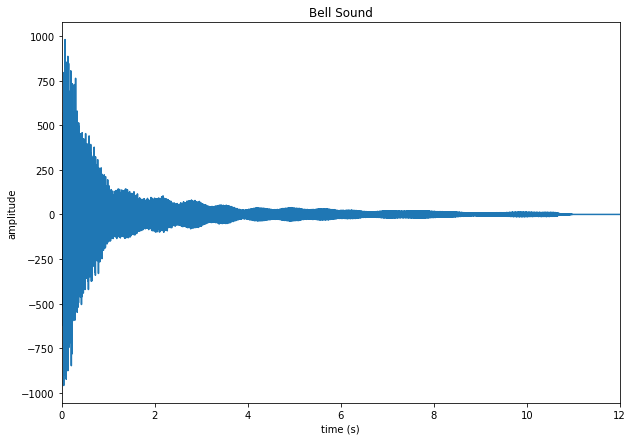

In [ ]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times, 0, 12, name='Bell Sound', w=10, h=7)

In [ ]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

## **Synthetic signal**

In [ ]:
#Synthesizing ESM
N = 63
f0 = 1/4
f1 = f0 + (1/N)
a0 = 1
a1 = 10
del0 = 0
del1 = -0.05
phi = np.random.uniform(-np.pi,np.pi,2)

Xt = Synthesis(N, np.array([del0, del1]), np.array([f0, f1]), np.array([a0, a1]), phi)

## **3.1 Spectral analysis by Fourier transform**

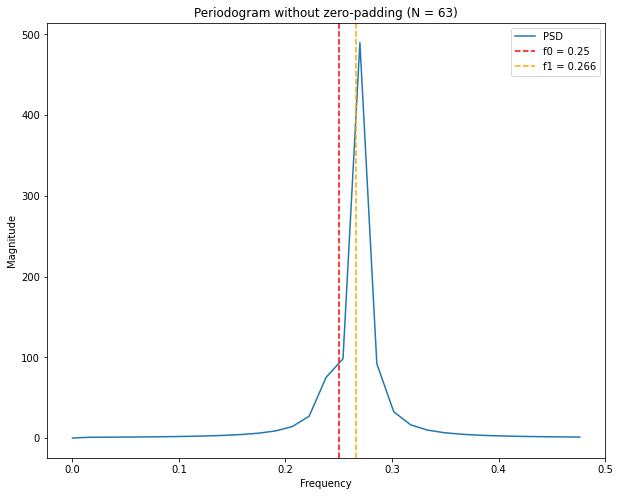

In [ ]:
freq, S = signal.periodogram(Xt, return_onesided=False)

plt.figure(figsize = [10,8])
plt.plot(freq[:31], S[:31], label = 'PSD')
plt.axvline(f0, color='r', ls='--', label=f'f0 = {f0}')
plt.axvline(f1, color='orange', ls='--', label='f1 = %.3f'%f1)
plt.ylabel('Magnitude')
plt.xlabel('Frequency')
plt.legend()
plt.title('Periodogram without zero-padding (N = 63)')
plt.show()

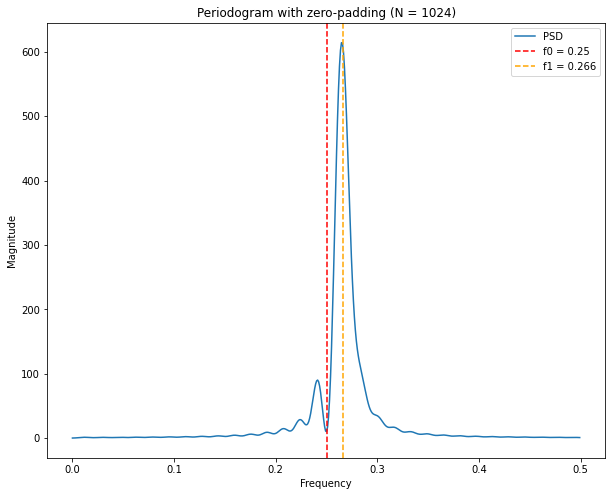

In [ ]:
freq, S = signal.periodogram(Xt, return_onesided=False, nfft = 1024)

plt.figure(figsize = [10,8])
plt.plot(freq[:512], S[:512], label = 'PSD')
plt.axvline(f0, color='r', ls='--', label=f'f0 = {f0}')
plt.axvline(f1, color='orange', ls='--', label='f1 = %.3f'%f1)
plt.ylabel('Magnitude')
plt.xlabel('Frequency')
plt.legend()
plt.title('Periodogram with zero-padding (N = 1024)')
plt.show()

In the first case, without zero-padding, we cannot observe two different peaks for each frequency, because the resolution (1/N) of the Fourier analysis is at its limit. In other words, the frequencies of the peaks differ from the resolution of the Fourier analysis limit. On the other hand, in the second case, with zero-padding, we improved the resolution by increasing the N. Thus, the zero-padding made the two peaks more distinguishable.

## **3.2 High resolution methods**


###**Computation of the empirical covariance matrix**

In [ ]:
#Function to compute the covariance matrix

def covMatrix(Xt, n):
  l = len(Xt) - n + 1
  matX = hankel(Xt[:n], Xt[n-1:])
  R = matX @ matX.conj().T
  return R/l

###**Estimation of the signal subspace**

In [ ]:
#Function to estimate the signal subspace

def returnBasis(R, K, noise=False):
  U1, eigen, U2 = svd(R)
  if noise == True:
    return U1[:, K:]
  else:
    return U1[:, :K]

## **3.2.1 ESPRIT method**

###**Estimation of the frequencies and damping factors**

In [ ]:
#Function to implement the ESPRIT method

def ESPRIT(Xt, n, K):
  
  Rxx = covMatrix(Xt, n)
  W = returnBasis(Rxx, K)
  Wdown = W[:-1,:]
  Wup = W[1:,:]
  
  Phi = pinv(Wdown) @ Wup
  poles = eig(Phi)[0]
  delta = np.log(np.abs(poles)) 
  freq = (1/(2*np.pi))*np.angle(poles)
  
  return delta, freq

###**Estimation of the amplitudes and phases**




In [ ]:
def LeastSquares(Xt, delta, f):
  #Calculating Vandermonde matrix
  t = np.arange(len(Xt)).reshape((len(Xt), 1))
  V = np.exp(t @ (delta + 1j*2*np.pi*f).reshape(1, len(f)))

  #OLS
  a = pinv(V) @ Xt

  return np.abs(a), np.angle(a)

###**Application to synthetic signals**

In [ ]:
n = 32
K = 2

#ESPRIT
deltaEst, freqEst = ESPRIT(Xt,n,K)

print('### Frequencies and Damping factors - ESPRIT method ###')
print('\n')
print(f'theoretical delta_0: {del0}        estimated delta_0: {round(deltaEst[1],2)}')
print(f'theoretical delta_1: {del1}    estimated delta_1: {round(deltaEst[0],2)}')
print('\n')
print(f'theoretical f0: {f0}     estimated f0: {freqEst[1]}')
print(f'theoretical f1: {round(f1,4)}   estimated f1: {round(freqEst[0],4)}')

### Frequencies and Damping factors - ESPRIT method ###


theoretical delta_0: 0        estimated delta_0: 0.0
theoretical delta_1: -0.05    estimated delta_1: -0.05


theoretical f0: 0.25     estimated f0: 0.25
theoretical f1: 0.2659   estimated f1: 0.2659


In [ ]:
#LeastSquares
aEst, phiEst = LeastSquares(Xt,deltaEst,freqEst)

print('### Amplitudes and Phases - Least Squares ###')
print('\n')
print(f'theoretical a0: {a0}     estimated a0: {round(aEst[1],3)}')
print(f'theoretical a1: {a1}    estimated a1: {round(aEst[0],3)}')
print('\n')
print(f'theoretical phi0: {round(phi[0],4)}     estimated phi0: {round(phiEst[1],4)}')
print(f'theoretical phi1: {round(phi[1],4)}    estimated phi1: {round(phiEst[0],4)}')

### Amplitudes and Phases - Least Squares ###


theoretical a0: 1     estimated a0: 1.0
theoretical a1: 10    estimated a1: 10.0


theoretical phi0: 3.0442     estimated phi0: 3.0442
theoretical phi1: 1.8558    estimated phi1: 1.8558


We can see that the ESPRIT method indeed gives accurate results for the estimation of the parameters of ESM model.

## **3.2.2 MUSIC method**

###**MUSIC pseudo-spectrum**

In [ ]:
def MUSIC(Xt, n, K, size = len(Xt)):
  Rxx = covMatrix(Xt, n)
  W = returnBasis(Rxx, K, noise = True)
  W = W.conj().T

  freq = np.linspace(0, 1, size)
  delta = np.linspace(-0.1, 0.1, size)
  t = np.arange(n)
  P = np.zeros((size,size))

  #Calculating Vandermonde matrix
  for i in range(size):
    for j in range(size):
      v = np.exp(t * (delta[i] + 1j*2*np.pi*freq[j]))
      P[i][j] = (1/((norm(W @ v))**2))

  freq, delta = np.meshgrid(freq, delta)
  fig = plt.figure(figsize=(20,8))
  ax = fig.add_subplot(projection='3d')
  ax.plot_surface(freq, delta, P, cmap=cm.coolwarm)
  ax.set_xlabel('Frequency')
  ax.set_ylabel('Damping Factor')

  plt.show()

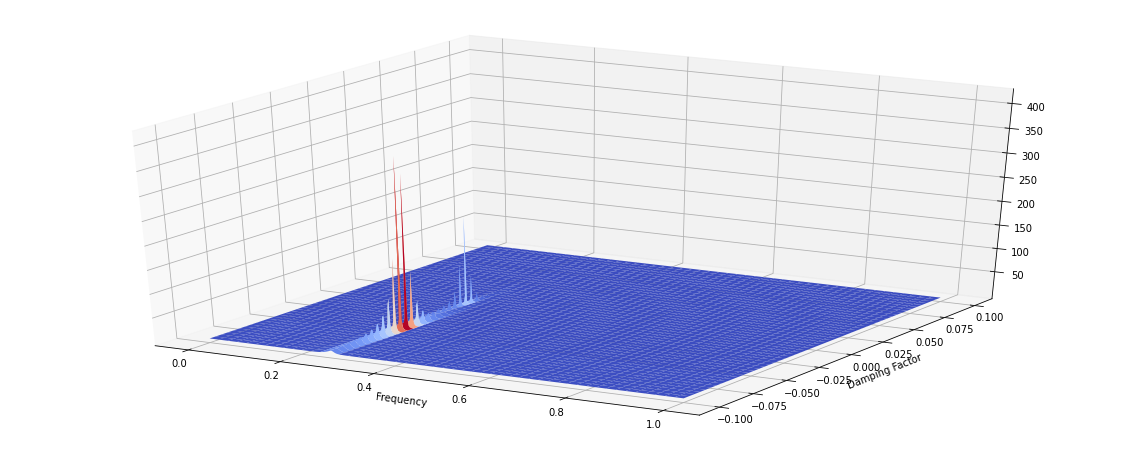

In [ ]:
MUSIC(Xt, 32, 2, size=500)

The result of the MUSIC method shows us that the poles are in the expected $[\delta_0, \delta_1]$ and $[f_0, f_1]$. Thus solving the MUSIC problem, we get the correct poles, the K highest peaks given by the figure above. 

# **Audio Signals**

## **4.1 Spectral Analysis by Fourier Transform**

In [ ]:
T_clocheA, data_clocheA, nframes_clocheA, nchannels_clocheA, sampling_frequency_clocheA = read_values('ClocheA.WAV')
Fs_clocheA = int(wavefile.getframerate())
x_clocheA = np.array(data_clocheA)
num_samples_clocheA = int(wavefile.getnframes())
IPython.display.Audio('ClocheA.WAV')

In [ ]:
T_clocheB, data_clocheB, nframes_clocheB, nchannels_clocheB, sampling_frequency_clocheB = read_values('ClocheB.WAV')
Fs_clocheB = int(wavefile.getframerate())
x_clocheB = np.array(data_clocheB)
num_samples_clocheB = int(wavefile.getnframes())
IPython.display.Audio('ClocheB.WAV')

In [ ]:
freq_clocheA, S_clocheA = signal.periodogram(x_clocheA, return_onesided=True)
freq_clocheB, S_clocheB = signal.periodogram(x_clocheB, return_onesided=True)

In [ ]:
fpA = freq_clocheA[np.argmax(S_clocheA)]
fpB = freq_clocheB[np.argmax(S_clocheB)]

print(f'The pitch of the cloche A is {fpA}')
print(f'The pitch of the cloche B is {fpB}')

The pitch of the cloche A is 0.05683510943050304
The pitch of the cloche B is 0.05683304162391614


Using the samplig frequency of the signals, we can calculate the frequency in hertz of the pitch, multiplying the normalized frequency by the sampling frequency. In this case, we get that the pitch of the bell sound is the musical note A  (La - multiples of 440 Hz).

In [ ]:
orders = np.array([0.5, 1, 1.2, 1.5, 2, 2.5, 2.6, 2.7, 3, 3.3, 3.7, 4.2])
eigenfreqA = fpA*orders
eigenfreqB = fpB*orders

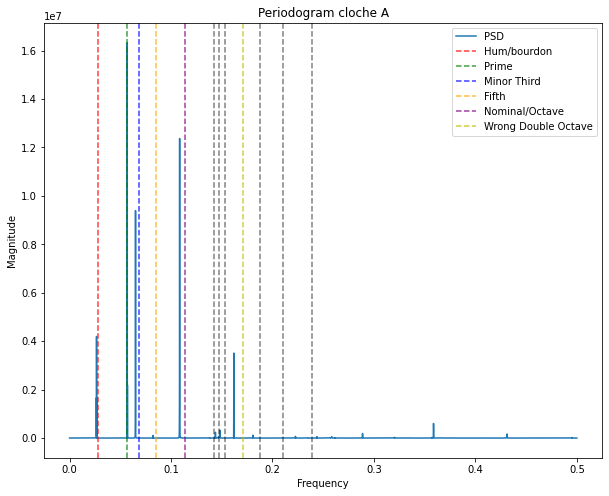

In [ ]:
plt.figure(figsize = [10,8])
plt.plot(freq_clocheA, S_clocheA.reshape(-1), label = 'PSD')
plt.axvline(eigenfreqA[0], color='r', ls='--', label=f'Hum/bourdon', alpha=0.75)
plt.axvline(eigenfreqA[1], color='g', ls='--', label=f'Prime', alpha=0.75)
plt.axvline(eigenfreqA[2], color='b', ls='--', label=f'Minor Third', alpha=0.75)
plt.axvline(eigenfreqA[3], color='orange', ls='--', label=f'Fifth', alpha=0.75)
plt.axvline(eigenfreqA[4], color='purple', ls='--', label=f'Nominal/Octave', alpha=0.75)
plt.axvline(eigenfreqA[5], color='black', ls='--', alpha=0.5)
plt.axvline(eigenfreqA[6], color='black', ls='--', alpha=0.5)
plt.axvline(eigenfreqA[7], color='black', ls='--', alpha=0.5)
plt.axvline(eigenfreqA[8], color='y', ls='--', label=f'Wrong Double Octave', alpha=0.75)
plt.axvline(eigenfreqA[9], color='black', ls='--', alpha=0.5)
plt.axvline(eigenfreqA[10], color='black', ls='--', alpha=0.5)
plt.axvline(eigenfreqA[11], color='black', ls='--', alpha=0.5)
plt.ylabel('Magnitude')
plt.xlabel('Frequency')
plt.legend()
plt.title('Periodogram cloche A')
plt.show()

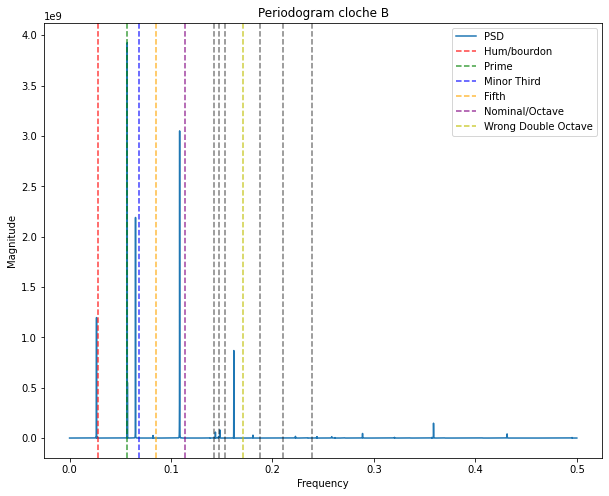

In [ ]:
plt.figure(figsize = [10,8])
plt.plot(freq_clocheB, S_clocheB.reshape(-1), label = 'PSD')
plt.axvline(eigenfreqB[0], color='r', ls='--', label=f'Hum/bourdon', alpha=0.75)
plt.axvline(eigenfreqB[1], color='g', ls='--', label=f'Prime', alpha=0.75)
plt.axvline(eigenfreqB[2], color='b', ls='--', label=f'Minor Third', alpha=0.75)
plt.axvline(eigenfreqB[3], color='orange', ls='--', label=f'Fifth', alpha=0.75)
plt.axvline(eigenfreqB[4], color='purple', ls='--', label=f'Nominal/Octave', alpha=0.75)
plt.axvline(eigenfreqB[5], color='black', ls='--', alpha=0.5)
plt.axvline(eigenfreqB[6], color='black', ls='--', alpha=0.5)
plt.axvline(eigenfreqB[7], color='black', ls='--', alpha=0.5)
plt.axvline(eigenfreqB[8], color='y', ls='--', label=f'Wrong Double Octave', alpha=0.75)
plt.axvline(eigenfreqB[9], color='black', ls='--', alpha=0.5)
plt.axvline(eigenfreqB[10], color='black', ls='--', alpha=0.5)
plt.axvline(eigenfreqB[11], color='black', ls='--', alpha=0.5)
plt.ylabel('Magnitude')
plt.xlabel('Frequency')
plt.legend()
plt.title('Periodogram cloche B')
plt.show()

## **High Resolution Method**



In [ ]:
x_clocheB = x_clocheB[0]

In [ ]:
n = 512
K = 54
l = 1024
N = n + l - 1
#ESPRIT
deltaEst, freqEst = ESPRIT(x_clocheB[10000:10000+N], n, K)
#LeastSquare
aEst, phiEst = LeastSquares(x_clocheB[10000:10000+N], deltaEst, freqEst)
#Synthesis
Cloche_synth = Synthesis(len(x_clocheB), -abs(deltaEst), freqEst, aEst, phiEst)

In [ ]:
ipd.Audio(np.real(Cloche_synth), rate=8000)

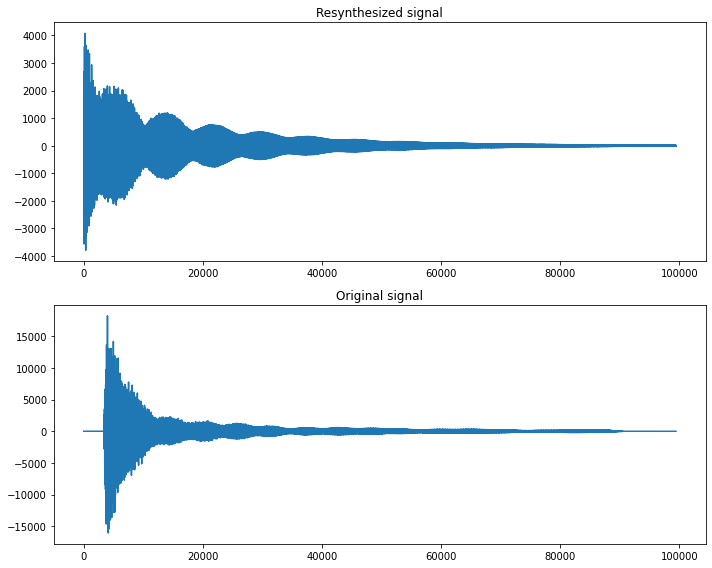

In [ ]:
fig, axs = plt.subplots(2, figsize = (10,8))
axs[0].plot(np.real(Cloche_synth))
axs[0].set_title('Resynthesized signal')
axs[1].plot(x_clocheB)
axs[1].set_title('Original signal')
plt.tight_layout()
plt.show()

Although the signal generated was not exactly the same, it was really similar to the original one. It sounds like it is missing some frequencies from the bell sound and that might be due to the fact that we take the information to synthetize the new signal from a small part of the previous one. 